### Objective- Applying Logistic Regresision on Amazon Fine Food Reviews to classify positive and negative reviews.

In [237]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.cross_validation import cross_val_score

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle


from tqdm import tqdm
import os

In [239]:
# using the SQLite Table to read data.
con = sqlite3.connect("/Users/mohdsaquib/Documents/data/database.sqlite") 



#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 100000""" , con) 


# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (100000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [240]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [241]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [242]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [243]:
display['COUNT(*)'].sum()

393063

### Exploratory Data Analysis

In [244]:
#### Data Cleaning : Deduplication
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that 

ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)

ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [245]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [246]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(87775, 10)

In [247]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

87.775

In [248]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [249]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]


In [250]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(87773, 10)


1    73592
0    14181
Name: Score, dtype: int64

### Preprocessing

[3.1]. Preprocessing Review Text
Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

Begin by removing the html tags
Remove any punctuations or limited set of special characters like , or . or # etc.
Check if the word is made up of english letters and is not alpha-numeric
Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
Convert the word to lowercase
Remove Stopwords
Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)
After which we collect the words used to describe positive and negative reviews

In [251]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [252]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [253]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [254]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [255]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

was way to hot for my blood, took a bite and did a jig  lol


In [256]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [257]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

was way to hot for my blood took a bite and did a jig lol


In [258]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
                "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])


### Preprocessing Review Text

In [259]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())


 17%|█▋        | 14847/87773 [00:14<01:14, 984.32it/s] 


 34%|███▎      | 29436/87773 [00:30<01:14, 786.95it/s]


 48%|████▊     | 41901/87773 [00:45<01:00, 760.62it/s]


 68%|██████▊   | 59884/87773 [01:01<00:13, 2032.88it/s]


 99%|█████████▉| 87202/87773 [01:15<00:00, 2052.05it/s]


100%|██████████| 87773/87773 [01:16<00:00, 1153.91it/s]

In [260]:
preprocessed_reviews[1500]

'way hot blood took bite jig lol'

### Preprocessing Review Summary

In [261]:
## preprocessing for review summary 
summary_preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Summary'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    summary_preprocessed_reviews.append(sentance.strip())

print(summary_preprocessed_reviews[1500])


 47%|████▋     | 41435/87773 [00:24<00:21, 2186.34it/s]


 74%|███████▍  | 65248/87773 [00:40<00:19, 1181.02it/s]


100%|██████████| 87773/87773 [00:53<00:00, 1645.01it/s]

hot stuff


### Feature Engineering 

In [262]:
# Adding review text and Summary text as Input into the data

preprocessed_reviews = [i + ' ' + j for i, j in zip(preprocessed_reviews,summary_preprocessed_reviews)] 
print(preprocessed_reviews[1500])

way hot blood took bite jig lol hot stuff


In [263]:
final['CleanedText']=preprocessed_reviews #adding a column of CleanedText which displays the data after pre-processing of the review 


In [264]:
final.head(3) #below the processed review can be seen in the CleanedText Column 


# store final table into an SQlLite table for future.
conn = sqlite3.connect('final.sqlite')
c=conn.cursor()
conn.text_factory = str
final.to_sql('Reviews', conn, schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)

In [265]:
con = sqlite3.connect("final.sqlite")
cleaned_data = pd.read_sql_query("select * from Reviews", con)

In [266]:
cleaned_data.shape

(87773, 12)

In [267]:
cleaned_data.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,22620,24750,2734888454,A13ISQV0U9GZIC,Sandikaye,1,1,0,1192060800,made in china,My dogs loves this chicken but its a product f...,dogs loves chicken product china wont buying a...
1,22621,24751,2734888454,A1C298ITT645B6,Hugh G. Pritchard,0,0,1,1195948800,Dog Lover Delites,Our dogs just love them. I saw them in a pet ...,dogs love saw pet store tag attached regarding...
2,70677,76870,B00002N8SM,A19Q006CSFT011,Arlielle,0,0,0,1288396800,only one fruitfly stuck,"I had an infestation of fruitflies, they were ...",infestation fruitflies literally everywhere fl...
3,70676,76869,B00002N8SM,A1FYH4S02BW7FN,wonderer,0,0,0,1290038400,Doesn't work!! Don't waste your money!!,Worst product I have gotten in long time. Woul...,worst product gotten long time would rate no s...
4,70675,76868,B00002N8SM,AUE8TB5VHS6ZV,eyeofthestorm,0,0,0,1306972800,A big rip off,I wish I'd read the reviews before making this...,wish would read reviews making purchase basica...


In [268]:
cleaned_data["Score"].value_counts()

1    73592
0    14181
Name: Score, dtype: int64

### Time based splitting

In [269]:
final = cleaned_data.sort_values('Time',axis= 0,inplace = False , na_position = 'last',ascending = True)
X = cleaned_data['CleanedText'].values
X = X[:100000]
y = cleaned_data['Score'].values
y = y[:100000]

In [270]:
# create design matrix X and target vector y
X = np.array(final.iloc[:,:]) # end index is exclusive
y = np.array(final['Score']) # showing you two ways of indexing a pandas df

In [271]:
from sklearn import cross_validation
# split the data set into train and test
X_1, X_test, y_1, y_test = cross_validation.train_test_split(X, y, test_size=0.3, random_state=0)

# split the train data set into cross validation train and cross validation test
X_train, X_cv, y_train, y_cv = cross_validation.train_test_split(X_1, y_1, test_size=0.3)


### Bag of Words

In [272]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
vectorizer.fit(X_train[:,9]) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_bow = vectorizer.transform(X_train[:,9])
X_cv_bow = vectorizer.transform(X_cv[:,9])
X_test_bow = vectorizer.transform(X_test[:,9])
print("After vectorizations")
print(X_train_bow.shape, y_train.shape)
print(X_cv_bow.shape, y_cv.shape)
print(X_test_bow.shape, y_test.shape)
print("="*100)

print(y_train.shape)
print(y_cv.shape)
print(y_test.shape)



After vectorizations
(43008, 10573) (43008,)
(18433, 10573) (18433,)
(26332, 10573) (26332,)
(43008,)
(18433,)
(26332,)


### Logistic Regression with L1-Regularizer

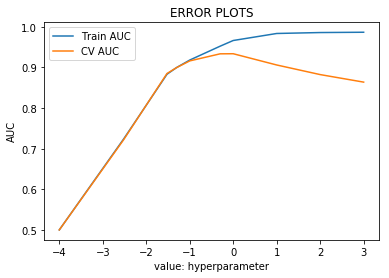

In [273]:
## Fit Logistic Regression to Train Data
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
C=[0.0001,0.003, 0.03,0.05, 0.1,0.5,1,10,100,1000]
train_auc = []
cv_auc = []
for value in C:
    i=0
    LR_BOW=LogisticRegression(penalty='l1',C=value,class_weight='balanced')
    LR_BOW.fit(X_train_bow,y_train)
    y_train_pred =  LR_BOW.predict_proba(X_train_bow)[:,1]
    y_cv_pred =  LR_BOW.predict_proba(X_cv_bow)[:,1]
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.plot((np.log10(C)), train_auc, label='Train AUC')
plt.plot((np.log10(C)), cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("value: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show() 


In [274]:
optimal_C = 1

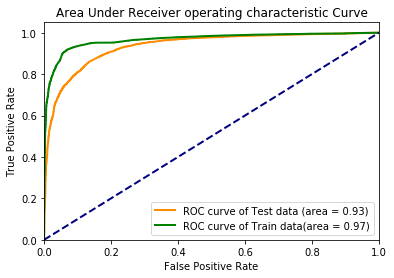

In [275]:
## finding roc_auc on test data
from sklearn.metrics import roc_curve, auc


LR = LogisticRegression(penalty='l1',C=1,class_weight='balanced')
LR.fit(X_train_bow, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_train, LR.predict_proba(X_train_bow)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, LR.predict_proba(X_test_bow)[:,1])

# Compute area under roc curve
area_train = auc(train_fpr, train_tpr)
area_test = auc(test_fpr, test_tpr)

lw =2
plt.plot(test_fpr, test_tpr, color='darkorange',lw=lw, label='ROC curve of Test data (area = %0.2f)' % area_test)
plt.plot(train_fpr, train_tpr, color='green',lw=lw, label='ROC curve of Train data(area = %0.2f)' % area_train)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Area Under Receiver operating characteristic Curve')
plt.legend(loc="lower right")
    

Text(33,0.5,'True Label')

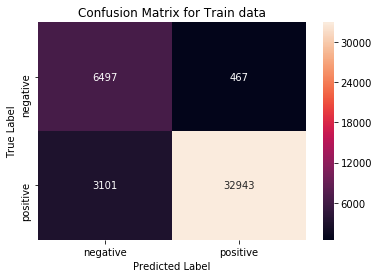

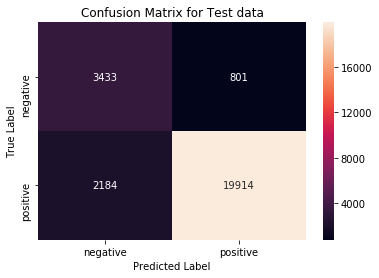

In [276]:
#Confusion matrix for train data
from sklearn.metrics import confusion_matrix    
plt.figure()
cm = confusion_matrix(y_train, LR.predict(X_train_bow))
class_label = ["negative", "positive"]
df_cm_train = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm_train , annot = True, fmt = "d")
plt.title("Confusion Matrix for Train data")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

#Confusion matrix for test data
plt.figure()
cm = confusion_matrix(y_test, LR.predict(X_test_bow))
class_label = ["negative", "positive"]
df_cm_test = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm_test , annot = True, fmt = "d")
plt.title("Confusion Matrix for Test data")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

### Observation-
#### From the above curve we can see that AUC of train data 0.96 and test data is 0.94.
#### From confusion matrix of train data we can see that 25504 negative points are correclty classified as negative and 136911 positive points are correctly classified as positive points.
#### From confusion matrix of train data we can see that 14491 negative points are correclty classified as negative and 82900 points are correctly classified as positive points.

In [277]:
# Variables that will be used for  making table in Conclusion part of this assignment

bow_l1_grid_C = optimal_C
ROC_L1_Train = area_train
ROC_L1_Test = area_test

### Calculating sparsity on weight vector obtained using L1 regularization on Bag of Words for various value of C

In [278]:
clf = LogisticRegression(penalty = 'l1', C = 0.1,class_weight = 'balanced')
clf.fit(X_train_bow,y_train)
train_fpr, train_tpr, thresholds = roc_curve(y_train, clf.predict_proba(X_train_bow)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test_bow)[:,1])
# Compute area under roc curve
area_train = auc(train_fpr, train_tpr)
area_test = auc(test_fpr, test_tpr)

print("AUC Score TRAIN",area_train)
print("AUC Score TEST",area_test)

## SPARSITY
w = clf.coef_
print('Sparsity',np.count_nonzero(w)-len(w))

AUC Score TRAIN 0.9182621827932431
AUC Score TEST 0.9138913474836381
Sparsity 324


In [279]:
clf = LogisticRegression(penalty = 'l1', C = 1,class_weight = 'balanced')
clf.fit(X_train_bow,y_train)
train_fpr, train_tpr, thresholds = roc_curve(y_train, clf.predict_proba(X_train_bow)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test_bow)[:,1])
# Compute area under roc curve
area_train = auc(train_fpr, train_tpr)
area_test = auc(test_fpr, test_tpr)

print("AUC Score TRAIN",area_train)
print("AUC Score TEST",area_test)

## SPARSITY
w = clf.coef_
print('Sparsity',np.count_nonzero(w)-len(w))

AUC Score TRAIN 0.9664143180416864
AUC Score TEST 0.9345548459297962
Sparsity 2495


In [280]:
clf = LogisticRegression(penalty = 'l1', C = 10,class_weight = 'balanced')
clf.fit(X_train_bow,y_train)
train_fpr, train_tpr, thresholds = roc_curve(y_train, clf.predict_proba(X_train_bow)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test_bow)[:,1])
# Compute area under roc curve
area_train = auc(train_fpr, train_tpr)
area_test = auc(test_fpr, test_tpr)

print("AUC Score TRAIN",area_train)
print("AUC Score TEST",area_test)

## SPARSITY
w = clf.coef_
print('Sparsity',np.count_nonzero(w)-len(w))

AUC Score TRAIN 0.9837052319773055
AUC Score TEST 0.913831569536534
Sparsity 6319


### Observation - 
*Using C=0.1 we get sparsity of 942.*
*Using C=1 we get sparsity of 5905.*
*Using C=10 we get sparsity of 15110.*


###  Applying Logistic Regression with L2 regularization on BOW

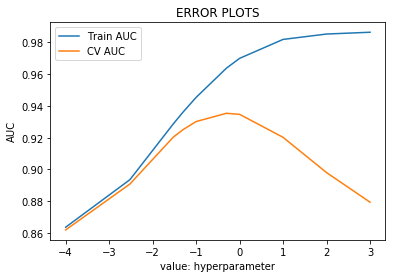

In [281]:
## Fit Logistic Regression to Train Data
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
C=[0.0001,0.003, 0.03,0.05, 0.1,0.5,1,10,100,1000]
train_auc = []
cv_auc = []
for value in C:
    i=0
    LR_BOW=LogisticRegression(penalty='l2',C=value,class_weight='balanced')
    LR_BOW.fit(X_train_bow,y_train)
    y_train_pred =  LR_BOW.predict_proba(X_train_bow)[:,1]
    y_cv_pred =  LR_BOW.predict_proba(X_cv_bow)[:,1]
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.plot((np.log10(C)), train_auc, label='Train AUC')
plt.plot((np.log10(C)), cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("value: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show() 

In [282]:
optimal_C = 1

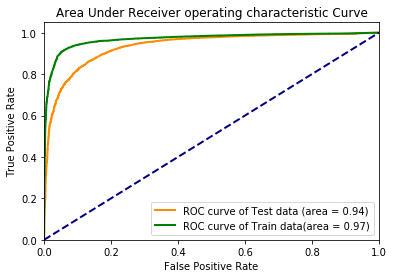

In [283]:
## finding roc_auc on test data
from sklearn.metrics import roc_curve, auc


LR = LogisticRegression(penalty='l2',C=1,class_weight='balanced')
LR.fit(X_train_bow, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_train, LR.predict_proba(X_train_bow)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, LR.predict_proba(X_test_bow)[:,1])

# Compute area under roc curve
area_train = auc(train_fpr, train_tpr)
area_test = auc(test_fpr, test_tpr)

lw =2
plt.plot(test_fpr, test_tpr, color='darkorange',lw=lw, label='ROC curve of Test data (area = %0.2f)' % area_test)
plt.plot(train_fpr, train_tpr, color='green',lw=lw, label='ROC curve of Train data(area = %0.2f)' % area_train)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Area Under Receiver operating characteristic Curve')
plt.legend(loc="lower right")
    

Text(33,0.5,'True Label')

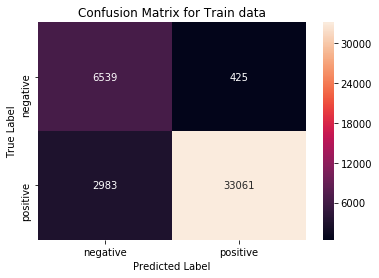

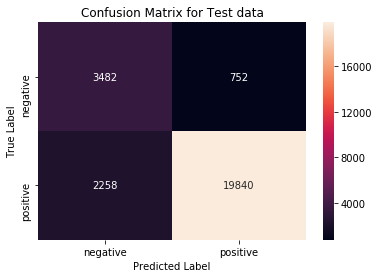

In [284]:
#Confusion matrix for train data
from sklearn.metrics import confusion_matrix    
plt.figure()
cm = confusion_matrix(y_train, LR.predict(X_train_bow))
class_label = ["negative", "positive"]
df_cm_train = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm_train , annot = True, fmt = "d")
plt.title("Confusion Matrix for Train data")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

#Confusion matrix for test data
plt.figure()
cm = confusion_matrix(y_test, LR.predict(X_test_bow))
class_label = ["negative", "positive"]
df_cm_test = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm_test , annot = True, fmt = "d")
plt.title("Confusion Matrix for Test data")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

### Observation-
#### From the above curve we can see that AUC of train data 0.96 and test data is 0.94.
#### From confusion matrix of train data we can see that 25604 negative points are correclty classified as negative and 137084 positive points are correctly classified as positive points.
#### From confusion matrix of train data we can see that 14590 negative points are correclty classified as negative and 82601 points are correctly classified as positive points.¶

In [285]:
# Variables that will be used for  making table in Conclusion part of this assignment

bow_l2_grid_C = optimal_C
ROC_L2_Train = area_train
ROC_L2_Test = area_test


### Performing pertubation test (multicollinearity check) on BOW(L2 Regularizer)

In [286]:
from sklearn.model_selection import GridSearchCV
mod  = LogisticRegression(penalty = 'l2', C = 1,class_weight = 'balanced')
mod.fit(X_train_bow,y_train)


LogisticRegression(C=1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [287]:
#perturbation testing
## getting the weight of coefficient
w = mod.coef_
print(w)

[[-0.18278838 -0.08463221  0.32283774 ...  1.11849724  0.01070758
   0.25036123]]


In [288]:
epsilon = np.random.normal(loc = 0,scale = 0.01, size = 1)
X_train_bow.data = X_train_bow.data + epsilon

In [289]:
clf_noise = LogisticRegression(penalty='l2',class_weight = 'balanced',C = 1)
clf_noise.fit(X_train_bow,y_train)

LogisticRegression(C=1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [290]:
w_1=clf_noise.coef_

In [291]:
per_array= np.abs((w-w_1)/w)*100
print("per_array: ",per_array)

per_array:  [[0.31548597 0.19400194 1.05010685 ... 0.24576221 0.16760883 0.98356859]]


In [292]:
#between 1st-100th percentile
for i in range(0,100,10):
    Weights = np.percentile(per_array, i)
    print("Weights = ",Weights)
print("**************************")


Weights =  0.0002154752723192153
Weights =  0.11276768796862068
Weights =  0.22991562373316551
Weights =  0.3498334932922609
Weights =  0.4605341100182414
Weights =  0.5952717320942695
Weights =  0.7287579480457331
Weights =  0.8957498610154799
Weights =  1.0633405148172848
Weights =  1.4575889357657277
**************************


In [293]:
#between 90th-100th percentile
for i in range(90,100,1):
    Weights = np.percentile(per_array, i)
    print("Weights = ",Weights)
print("**************************")

Weights =  1.4575889357657277
Weights =  1.5245504666760217
Weights =  1.6133174405271935
Weights =  1.7434415371069492
Weights =  1.919338107024469
Weights =  2.1790567637291085
Weights =  2.5125550803930574
Weights =  3.027637924544055
Weights =  3.936814402756548
Weights =  6.525305623512232
**************************


In [294]:
#between 99th-100th percentile
k=98
for i in range(1,12,1):
    Weights_3 = np.percentile(per_array, k)
    print("Weights = ",Weights_3)   
    k+=0.1
print("**************************")

Weights =  3.936814402756548
Weights =  4.138585961378279
Weights =  4.35316388463994
Weights =  4.622521846998
Weights =  4.881081464381442
Weights =  5.165473896710531
Weights =  5.297215813964155
Weights =  5.468032079441803
Weights =  5.761048284421612
Weights =  5.986666473091609
Weights =  6.525305623512177
**************************


In [295]:
#between 99.6th - 99.8th percentile
Weight_chng = []
#Weight_chng = np.asarray(Weights_4)
k=99.8
for i in range(1,3):
    Weights_3 = np.percentile(per_array, k)
    print("Weights = ",Weights_3) 
    Weight_chng.append(Weights_3)
    #Weight_chng = Weights_3
    k+=0.1
print("**************************")

print(Weight_chng)
thrsh = np.abs(Weight_chng[0] - Weight_chng[1]) #taking threshold value for weight change
print("Threshold value = ",thrsh)

Weights =  26.93969625666385
Weights =  63.978473080978816
**************************
[26.93969625666385, 63.978473080978816]
Threshold value =  37.038776824314965


### Observation 
#### The weight change for 99.9 percentile to 100 percentile is large , so we put our threshold as 18.03.

#### Printing the feature whose percentage change is more than the threshold.

In [296]:
Weight_chng_3 = []
loop2 = np.shape(X_train_bow)

for loop1 in range(0,loop2[1]):
    Weight_chng_3[0:loop1] = np.abs((w-w_1)/w)*100
Weight_chng_2 = np.asarray(Weight_chng_3)


loop4 = 0
index2 = []
for loop3 in range(0,loop2[1]):    
    if (Weight_chng_2[0,loop3] >= thrsh):
        index2.append(loop3)
        loop4 +=1
        
leng = len(index2)
print("Threshhold taken for abrupt changes = ",thrsh)
print("Number of features with abrupt changes = ",leng)
print("\n")

feature_names = vectorizer.get_feature_names()

for k in index2:
     print("Feature Names: ",feature_names[k])

Threshhold taken for abrupt changes =  37.038776824314965
Number of features with abrupt changes =  15


Feature Names:  additives
Feature Names:  change
Feature Names:  chile
Feature Names:  cover
Feature Names:  directions
Feature Names:  freezer
Feature Names:  highly
Feature Names:  jasmine
Feature Names:  know
Feature Names:  pack
Feature Names:  paprika
Feature Names:  pure
Feature Names:  question
Feature Names:  support
Feature Names:  switched


### Feature Importance on BOW - Top 10 positive and negative features

In [297]:
def show_most_informative_features(vectorizer, clf, n=10):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    print("\t\t\tNegative\t\t\t\t\t\tPositive")
    print("________________________________________________________________________________________________")
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print("\t%.4f\t%-15s\t\t\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))
        
show_most_informative_features(vectorizer,clf)
#Code Reference:https://stackoverflow.com/questions/11116697/how-to-get-most-informative-features-for-scikit-learn-classifiers

			Negative						Positive
________________________________________________________________________________________________
	-20.3551	puts           				15.7636	seasonings     
	-15.6589	dassant        				13.6557	alone          
	-14.8150	disappointment 				12.8133	yorkie         
	-14.1239	ostrim         				12.5924	curl           
	-13.8504	terribleness   				12.4355	ghirardelli    
	-13.7010	vinci          				11.8923	weedy          
	-11.8509	sadie          				11.6989	healthfood     
	-11.3467	moldy          				10.6188	goodbye        
	-11.2562	brûl           				10.5409	stable         
	-11.2461	transit        				10.2100	ey             


### Logistic Regression on TFIDF(L1- Regularizer)

In [298]:
#tf-idf on train data
tf_idf_vect = TfidfVectorizer(ngram_range=(1,1)) #considering only uni-gram as I was getting memory error
train_tfidf = tf_idf_vect.fit_transform(X_train[:,9]) #sparse matrix
cv_tfidf= tf_idf_vect.transform(X_cv[:,9])
test_tfidf = tf_idf_vect.transform(X_test[:,9])
print(train_tfidf.shape)
print(cv_tfidf.shape)
print(test_tfidf.shape)

(43008, 10573)
(18433, 10573)
(26332, 10573)


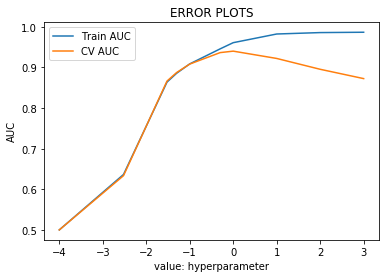

In [299]:
## Fit Logistic Regression to Train Data
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
C=[0.0001,0.003, 0.03,0.05, 0.1,0.5,1,10,100,1000]
train_auc = []
cv_auc = []
for value in C:
    i=0
    LR_tfidf=LogisticRegression(penalty='l1',C=value,class_weight='balanced')
    LR_tfidf.fit(train_tfidf,y_train)
    y_train_pred =  LR_tfidf.predict_proba(train_tfidf)[:,1]
    y_cv_pred =  LR_tfidf.predict_proba(cv_tfidf)[:,1]
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.plot((np.log10(C)), train_auc, label='Train AUC')
plt.plot((np.log10(C)), cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("value: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show() 

In [300]:
optimal_C2 = 1

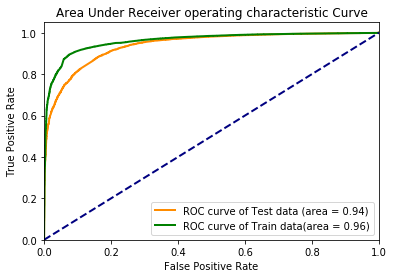

In [301]:
## finding roc_auc on test data
from sklearn.metrics import roc_curve, auc


LR = LogisticRegression(penalty='l1',C=optimal_C2,class_weight='balanced')
LR.fit(train_tfidf, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_train, LR.predict_proba(train_tfidf)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, LR.predict_proba(test_tfidf)[:,1])

# Compute area under roc curve
area_train = auc(train_fpr, train_tpr)
area_test = auc(test_fpr, test_tpr)

lw =2
plt.plot(test_fpr, test_tpr, color='darkorange',lw=lw, label='ROC curve of Test data (area = %0.2f)' % area_test)
plt.plot(train_fpr, train_tpr, color='green',lw=lw, label='ROC curve of Train data(area = %0.2f)' % area_train)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Area Under Receiver operating characteristic Curve')
plt.legend(loc="lower right")
    

Text(33,0.5,'True Label')

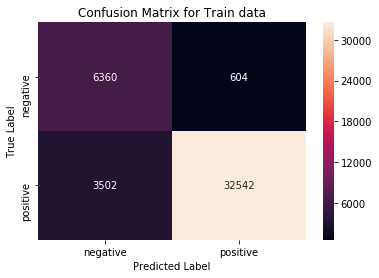

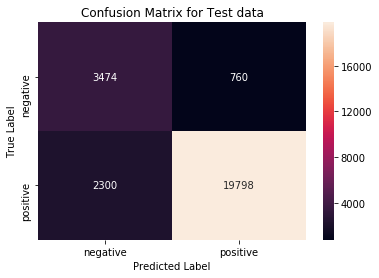

In [302]:
#Confusion matrix for train data
from sklearn.metrics import confusion_matrix    
plt.figure()
cm = confusion_matrix(y_train, LR.predict(train_tfidf))
class_label = ["negative", "positive"]
df_cm_train = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm_train , annot = True, fmt = "d")
plt.title("Confusion Matrix for Train data")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

#Confusion matrix for test data
plt.figure()
cm = confusion_matrix(y_test, LR.predict(test_tfidf))
class_label = ["negative", "positive"]
df_cm_test = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm_test , annot = True, fmt = "d")
plt.title("Confusion Matrix for Test data")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

### Observation - 
#### From the above curve we can see that AUC of train data 0.96 and test data is 0.95.
#### From confusion matrix of train data we can see that 25372 negative points are correclty classified as negative and 136399 positive points are correctly classified as positive points.
#### From confusion matrix of train data we can see that 14683 negative points are correclty classified as negative and 82659 points are correctly classified as positive points.¶

In [303]:
# Variables that will be used for  making table in Conclusion part of this assignment

tfidf_l1_grid_C = optimal_C2
ROC_tfidf_L1_Train = area_train
ROC_tfidf_L1_Test = area_test


### TFIDF L2 Regularizer

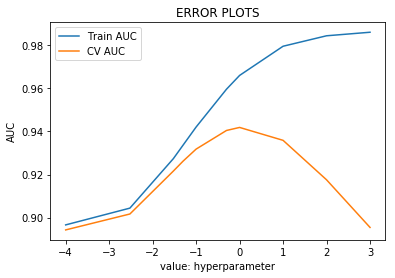

In [304]:
## Fit Logistic Regression to Train Data
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
C=[0.0001,0.003, 0.03,0.05, 0.1,0.5,1,10,100,1000]
train_auc = []
cv_auc = []
for value in C:
    i=0
    LR_tf=LogisticRegression(penalty='l2',C=value,class_weight='balanced')
    LR_tf.fit(train_tfidf,y_train)
    y_train_pred =  LR_tf.predict_proba(train_tfidf)[:,1]
    y_cv_pred =  LR_tf.predict_proba(cv_tfidf)[:,1]
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.plot((np.log10(C)), train_auc, label='Train AUC')
plt.plot((np.log10(C)), cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("value: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show() 

In [305]:
optimal_C2 = 1

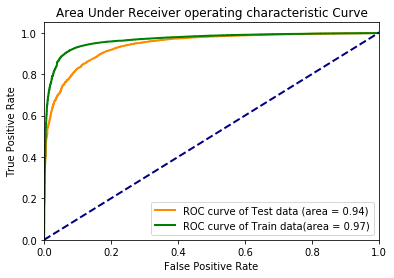

In [306]:
## finding roc_auc on test data
from sklearn.metrics import roc_curve, auc


LR = LogisticRegression(penalty='l2',C=optimal_C2,class_weight='balanced')
LR.fit(train_tfidf, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_train, LR.predict_proba(train_tfidf)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, LR.predict_proba(test_tfidf)[:,1])

# Compute area under roc curve
area_train = auc(train_fpr, train_tpr)
area_test = auc(test_fpr, test_tpr)

lw =2
plt.plot(test_fpr, test_tpr, color='darkorange',lw=lw, label='ROC curve of Test data (area = %0.2f)' % area_test)
plt.plot(train_fpr, train_tpr, color='green',lw=lw, label='ROC curve of Train data(area = %0.2f)' % area_train)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Area Under Receiver operating characteristic Curve')
plt.legend(loc="lower right")

Text(33,0.5,'True Label')

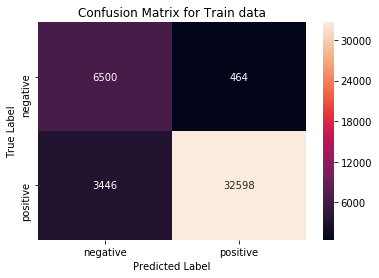

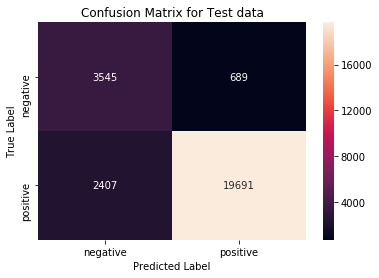

In [307]:
#Confusion matrix for train data
from sklearn.metrics import confusion_matrix    
plt.figure()
cm = confusion_matrix(y_train, LR.predict(train_tfidf))
class_label = ["negative", "positive"]
df_cm_train = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm_train , annot = True, fmt = "d")
plt.title("Confusion Matrix for Train data")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

#Confusion matrix for test data
plt.figure()
cm = confusion_matrix(y_test, LR.predict(test_tfidf))
class_label = ["negative", "positive"]
df_cm_test = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm_test , annot = True, fmt = "d")
plt.title("Confusion Matrix for Test data")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

### Observation
#### From the above curve we can see that AUC of train data 0.96 and test data is 0.95.
#### From confusion matrix of train data we can see that 25659 negative points are correclty classified as negative and 136200 positive points are correctly classified as positive points.
#### From confusion matrix of train data we can see that 14817 negative points are correclty classified as negative and 82271 points are correctly classified as positive points.¶

### Top 10 positive and negative features

In [308]:
def show_most_informative_features(vectorizer, LR, n=10):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(LR.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    print("\t\t\tNegative\t\t\t\t\t\tPositive")
    print("________________________________________________________________________________________________")
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print("\t%.4f\t%-15s\t\t\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))
        
show_most_informative_features(vectorizer,clf)
#Code Reference:https://stackoverflow.com/questions/11116697/how-to-get-most-informative-features-for-scikit-learn-classifiers

			Negative						Positive
________________________________________________________________________________________________
	-20.3551	puts           				15.7636	seasonings     
	-15.6589	dassant        				13.6557	alone          
	-14.8150	disappointment 				12.8133	yorkie         
	-14.1239	ostrim         				12.5924	curl           
	-13.8504	terribleness   				12.4355	ghirardelli    
	-13.7010	vinci          				11.8923	weedy          
	-11.8509	sadie          				11.6989	healthfood     
	-11.3467	moldy          				10.6188	goodbye        
	-11.2562	brûl           				10.5409	stable         
	-11.2461	transit        				10.2100	ey             


In [309]:
# Variables that will be used for  making table in Conclusion part of this assignment

tfidf_l2_grid_C = optimal_C2
ROC_tfidf_L2_Train = area_train
ROC_tfidf_L2_Test = area_test


### AVG -W2V

In [310]:
#w2v
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sent=[]
for sent in final['CleanedText'].values:
    list_of_sent.append(sent.split())
    
print(type(list_of_sent))
print(final['CleanedText'].values[0])
print("*****************************************************************")
print(list_of_sent[0])

<class 'list'>
bought apartment infested fruit flies hours trap attracted many flies within days practically gone may not long term solution flies driving crazy consider buying one caution surface sticky try avoid touching sure death flies
*****************************************************************
['bought', 'apartment', 'infested', 'fruit', 'flies', 'hours', 'trap', 'attracted', 'many', 'flies', 'within', 'days', 'practically', 'gone', 'may', 'not', 'long', 'term', 'solution', 'flies', 'driving', 'crazy', 'consider', 'buying', 'one', 'caution', 'surface', 'sticky', 'try', 'avoid', 'touching', 'sure', 'death', 'flies']


In [311]:
w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=4)
w2v_words = list(w2v_model.wv.vocab)

In [312]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
#print(len(sent_vectors[0]))
print(type(sent_vectors))

87773
<class 'list'>


In [313]:
# create design matrix X and target vector y
X = np.array(sent_vectors[::]) # end index is exclusive
y = np.array(final['Score']) # showing you two ways of indexing a pandas df

In [314]:
# split the data set into train and test
X_1, X_test_avgw2v, y_1, y_test = cross_validation.train_test_split(X, y, test_size=0.3, random_state=0)

# split the train data set into cross validation train and cross validation test
X_train_avgw2v, X_cv_avgw2v, y_train, y_cv = cross_validation.train_test_split(X_1, y_1, test_size=0.3)


### AVG-W2V L1 Regularizer

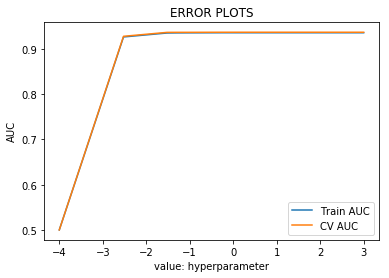

In [315]:
## Fit Logistic Regression to Train Data
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
C=[0.0001,0.003, 0.03,0.05, 0.1,0.5,1,10,100,1000]
train_auc = []
cv_auc = []
for value in C:
    i=0
    LR_avg=LogisticRegression(penalty='l1',C=value,class_weight='balanced')
    LR_avg.fit(X_train_avgw2v,y_train)
    y_train_pred =  LR_avg.predict_proba(X_train_avgw2v)[:,1]
    y_cv_pred =  LR_avg.predict_proba(X_cv_avgw2v)[:,1]
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.plot((np.log10(C)), train_auc, label='Train AUC')
plt.plot((np.log10(C)), cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("value: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show() 

In [316]:
optimal_C = 3

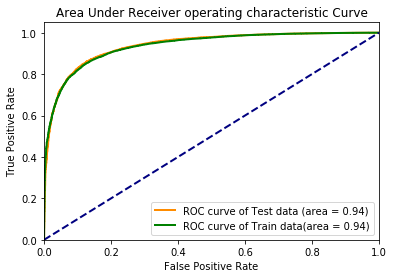

In [317]:
## finding roc_auc on test data
from sklearn.metrics import roc_curve, auc


LR = LogisticRegression(penalty='l1',C=optimal_C,class_weight='balanced')
LR.fit(X_train_avgw2v, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_train, LR.predict_proba(X_train_avgw2v)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, LR.predict_proba(X_test_avgw2v)[:,1])

# Compute area under roc curve
area_train = auc(train_fpr, train_tpr)
area_test = auc(test_fpr, test_tpr)

lw =2
plt.plot(test_fpr, test_tpr, color='darkorange',lw=lw, label='ROC curve of Test data (area = %0.2f)' % area_test)
plt.plot(train_fpr, train_tpr, color='green',lw=lw, label='ROC curve of Train data(area = %0.2f)' % area_train)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Area Under Receiver operating characteristic Curve')
plt.legend(loc="lower right")

Text(33,0.5,'True Label')

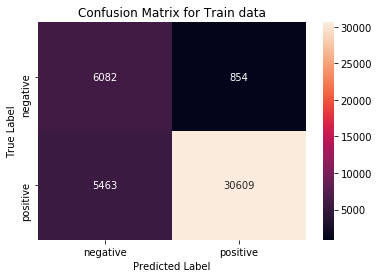

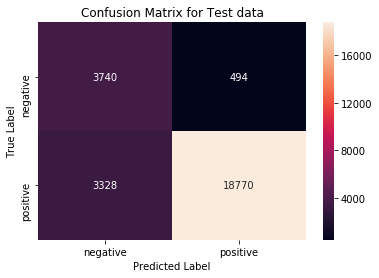

In [318]:
#Confusion matrix for train data
from sklearn.metrics import confusion_matrix    
plt.figure()
cm = confusion_matrix(y_train, LR.predict(X_train_avgw2v))
class_label = ["negative", "positive"]
df_cm_train = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm_train , annot = True, fmt = "d")
plt.title("Confusion Matrix for Train data")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

#Confusion matrix for test data
plt.figure()
cm = confusion_matrix(y_test, LR.predict(X_test_avgw2v))
class_label = ["negative", "positive"]
df_cm_test = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm_test , annot = True, fmt = "d")
plt.title("Confusion Matrix for Test data")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

### Observation
#### From the above curve we can see that AUC of train data 0.96 and test data is 0.95.
#### From confusion matrix of train data we can see that 24811 negative points are correclty classified as negative and 130775 positive points are correctly classified as positive points.
#### From confusion matrix of train data we can see that 15193 negative points are correclty classified as negative and 80171 points are correctly classified as positive points.¶

### Top 10 positve and negative features 

In [319]:
def show_most_informative_features(vectorizer, LR, n=10):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(LR.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    print("\t\t\tNegative\t\t\t\t\t\tPositive")
    print("________________________________________________________________________________________________")
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print("\t%.4f\t%-15s\t\t\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))
        
show_most_informative_features(vectorizer,clf)
#Code Reference:https://stackoverflow.com/questions/11116697/how-to-get-most-informative-features-for-scikit-learn-classifiers

			Negative						Positive
________________________________________________________________________________________________
	-20.3551	puts           				15.7636	seasonings     
	-15.6589	dassant        				13.6557	alone          
	-14.8150	disappointment 				12.8133	yorkie         
	-14.1239	ostrim         				12.5924	curl           
	-13.8504	terribleness   				12.4355	ghirardelli    
	-13.7010	vinci          				11.8923	weedy          
	-11.8509	sadie          				11.6989	healthfood     
	-11.3467	moldy          				10.6188	goodbye        
	-11.2562	brûl           				10.5409	stable         
	-11.2461	transit        				10.2100	ey             


In [320]:
# Variables that will be used for  making table in Conclusion part of this assignment

avgw2v_L1_grid_C = optimal_C
ROC_avgw2v_L1_Train = area_train
ROC_avgw2v_L1_Test = area_test


### AVG-W2V L2 Regularizer 

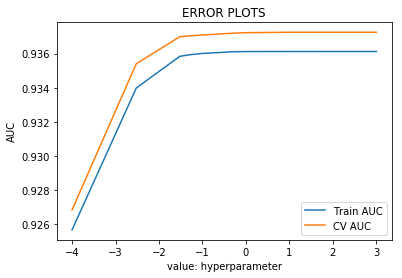

In [321]:
## Fit Logistic Regression to Train Data
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
C=[0.0001,0.003, 0.03,0.05, 0.1,0.5,1,10,100,1000]
train_auc = []
cv_auc = []
for value in C:
    i=0
    LR_avg=LogisticRegression(penalty='l2',C=value,class_weight='balanced')
    LR_avg.fit(X_train_avgw2v,y_train)
    y_train_pred =  LR_avg.predict_proba(X_train_avgw2v)[:,1]
    y_cv_pred =  LR_avg.predict_proba(X_cv_avgw2v)[:,1]
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.plot((np.log10(C)), train_auc, label='Train AUC')
plt.plot((np.log10(C)), cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("value: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show() 

In [322]:
optimal_C = 3

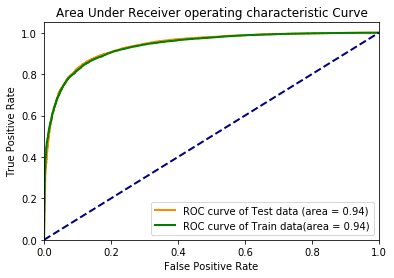

In [323]:
## finding roc_auc on test data
from sklearn.metrics import roc_curve, auc


LR = LogisticRegression(penalty='l2',C=optimal_C,class_weight='balanced')
LR.fit(X_train_avgw2v, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_train, LR.predict_proba(X_train_avgw2v)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, LR.predict_proba(X_test_avgw2v)[:,1])

# Compute area under roc curve
area_train = auc(train_fpr, train_tpr)
area_test = auc(test_fpr, test_tpr)

lw =2
plt.plot(test_fpr, test_tpr, color='darkorange',lw=lw, label='ROC curve of Test data (area = %0.2f)' % area_test)
plt.plot(train_fpr, train_tpr, color='green',lw=lw, label='ROC curve of Train data(area = %0.2f)' % area_train)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Area Under Receiver operating characteristic Curve')
plt.legend(loc="lower right")

Text(33,0.5,'True Label')

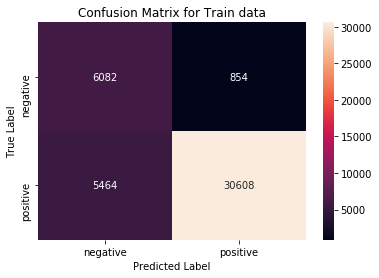

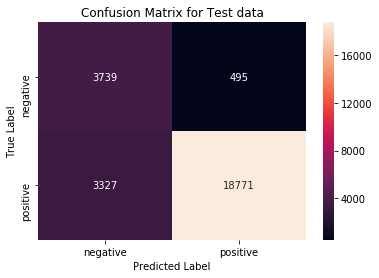

In [324]:
#Confusion matrix for train data
from sklearn.metrics import confusion_matrix    
plt.figure()
cm = confusion_matrix(y_train, LR.predict(X_train_avgw2v))
class_label = ["negative", "positive"]
df_cm_train = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm_train , annot = True, fmt = "d")
plt.title("Confusion Matrix for Train data")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

#Confusion matrix for test data
plt.figure()
cm = confusion_matrix(y_test, LR.predict(X_test_avgw2v))
class_label = ["negative", "positive"]
df_cm_test = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm_test , annot = True, fmt = "d")
plt.title("Confusion Matrix for Test data")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

### Observation
#### From the above curve we can see that AUC of train data 0.95 and test data is 0.95.
#### From confusion matrix of train data we can see that 25812 negative points are correclty classified as negative and 130772 positive points are correctly classified as positive points.
#### From confusion matrix of train data we can see that 15192 negative points are correclty classified as negative and 80175 points are correctly classified as positive points.¶

In [325]:
def show_most_informative_features(vectorizer, LR, n=10):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(LR.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    print("\t\t\tNegative\t\t\t\t\t\tPositive")
    print("________________________________________________________________________________________________")
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print("\t%.4f\t%-15s\t\t\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))
        
show_most_informative_features(vectorizer,clf)
#Code Reference:https://stackoverflow.com/questions/11116697/how-to-get-most-informative-features-for-scikit-learn-classifiers

			Negative						Positive
________________________________________________________________________________________________
	-20.3551	puts           				15.7636	seasonings     
	-15.6589	dassant        				13.6557	alone          
	-14.8150	disappointment 				12.8133	yorkie         
	-14.1239	ostrim         				12.5924	curl           
	-13.8504	terribleness   				12.4355	ghirardelli    
	-13.7010	vinci          				11.8923	weedy          
	-11.8509	sadie          				11.6989	healthfood     
	-11.3467	moldy          				10.6188	goodbye        
	-11.2562	brûl           				10.5409	stable         
	-11.2461	transit        				10.2100	ey             


In [326]:
# Variables that will be used for  making table in Conclusion part of this assignment

avgw2v_L2_grid_C = optimal_C
ROC_avgw2v_L2_Train = area_train
ROC_avgw2v_L2_Test = area_test


### Tfidf-W2V

In [327]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())

In [328]:
# min_count = 5 considers only words that occured atleast 5 times
w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
print(w2v_model.wv.most_similar('great'))
print('='*50)
print(w2v_model.wv.most_similar('worst'))
    

[('excellent', 0.8575621247291565), ('fantastic', 0.8390671014785767), ('awesome', 0.8295279741287231), ('terrific', 0.8180358409881592), ('good', 0.8036769032478333), ('wonderful', 0.7549224495887756), ('perfect', 0.7453899383544922), ('nice', 0.698211133480072), ('fabulous', 0.6851657629013062), ('amazing', 0.6728402376174927)]
[('nastiest', 0.7276686429977417), ('greatest', 0.7225097417831421), ('tastiest', 0.7052749395370483), ('best', 0.6830121278762817), ('coolest', 0.6682201027870178), ('disgusting', 0.6589139699935913), ('awful', 0.6389209628105164), ('surpass', 0.6128308773040771), ('nicest', 0.5987083911895752), ('freshest', 0.5983957052230835)]


In [329]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  17916
sample words  ['dogs', 'loves', 'chicken', 'product', 'china', 'wont', 'buying', 'anymore', 'hard', 'find', 'products', 'made', 'usa', 'one', 'isnt', 'bad', 'good', 'take', 'chances', 'till', 'know', 'going', 'imports', 'love', 'saw', 'pet', 'store', 'tag', 'attached', 'regarding', 'satisfied', 'safe', 'dog', 'lover', 'infestation', 'literally', 'everywhere', 'flying', 'around', 'kitchen', 'bought', 'hoping', 'least', 'get', 'rid', 'weeks', 'fly', 'stuck', 'squishing', 'buggers']


In [330]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))



  3%|▎         | 2828/87773 [00:17<06:48, 207.94it/s]


  7%|▋         | 6054/87773 [00:34<09:23, 144.97it/s]


 10%|█         | 9090/87773 [00:50<07:30, 174.67it/s]


 14%|█▍        | 12310/87773 [01:07<09:06, 138.00it/s]


 17%|█▋        | 15005/87773 [01:24<08:24, 144.22it/s]


 21%|██        | 18149/87773 [01:40<06:18, 183.95it/s]


 24%|██▍       | 21119/87773 [01:56<07:07, 155.99it/s]


 27%|██▋       | 23861/87773 [02:14<06:18, 168.64it/s]


 31%|███       | 26833/87773 [02:30<06:34, 154.48it/s]


 34%|███▍      | 29806/87773 [02:47<05:44, 168.27it/s]


 37%|███▋      | 32704/87773 [03:04<05:33, 165.19it/s]


 40%|████      | 35465/87773 [03:21<05:27, 159.69it/s]


 44%|████▍     | 38560/87773 [03:38<05:22, 152.56it/s]


 47%|████▋     | 41469/87773 [03:54<08:02, 96.01it/s]


 51%|█████     | 44366/87773 [04:11<03:45, 192.16it/s]


 53%|█████▎    | 46874/87773 [04:28<04:23, 155.43it/s]


 57%|█████▋    | 49697/87773 [04:45<04:39, 136.20it/s]


 60%|█████▉    | 52305/87773 [05:02<05:30, 107.42it/s]


 62%|██████▏   | 54448/87773 [05:21<05:18, 104.52it/s]


 64%|██████▍   | 55975/87773 [05:40<05:11, 101.93it/s]


 68%|██████▊   | 60065/87773 [05:58<01:43, 268.58it/s]


 73%|███████▎  | 64482/87773 [06:14<01:12, 320.92it/s]


 79%|███████▉  | 69123/87773 [06:31<01:08, 270.97it/s]


 83%|████████▎ | 73132/87773 [06:48<01:00, 243.43it/s]


 87%|████████▋ | 76770/87773 [07:05<00:47, 233.02it/s]


 92%|█████████▏| 80922/87773 [07:22<00:29, 233.35it/s]


 97%|█████████▋| 84801/87773 [07:39<00:09, 304.30it/s]


100%|██████████| 87773/87773 [07:50<00:00, 186.50it/s]

87773
50


In [331]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [332]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1


  0%|          | 350/87773 [00:26<4:28:24,  5.43it/s]


  1%|          | 710/87773 [00:53<2:31:47,  9.56it/s]


  1%|          | 1085/87773 [01:18<2:24:53,  9.97it/s]


  2%|▏         | 1470/87773 [01:43<1:56:15, 12.37it/s]


  2%|▏         | 1866/87773 [02:07<1:35:41, 14.96it/s]


  3%|▎         | 2263/87773 [02:32<1:26:09, 16.54it/s]


  3%|▎         | 2682/87773 [02:57<1:28:50, 15.96it/s]


  3%|▎         | 3056/87773 [03:22<1:10:36, 20.00it/s]


  4%|▍         | 3416/87773 [03:49<1:12:48, 19.31it/s]


  4%|▍         | 3809/87773 [04:12<1:28:53, 15.74it/s]


  5%|▍         | 4181/87773 [04:38<1:10:51, 19.66it/s]


  5%|▌         | 4555/87773 [05:03<1:13:00, 19.00it/s]


  6%|▌         | 4926/87773 [05:27<1:41:00, 13.67it/s]


  6%|▌         | 5296/87773 [05:50<1:16:39, 17.93it/s]


  6%|▋         | 5696/87773 [06:13<1:15:38, 18.08it/s]


  7%|▋         | 6047/87773 [06:39<1:17:14, 17.63it/s]


  7%|▋         | 6394/87773 [07:07<1:06:48, 20.30it/s]


  8%|▊         | 6761/87773 [07:31<1:16:33, 17.64it/s]


  8%|▊         | 7159/87773 [07:55<56:59, 23.57it/s]  


  9%|▊         | 7526/87773 [08:19<1:13:38, 18.16it/s]


  9%|▉         | 7925/87773 [08:42<1:15:40, 17.59it/s]


  9%|▉         | 8292/87773 [09:06<1:22:57, 15.97it/s]


 10%|▉         | 8666/87773 [09:30<2:00:32, 10.94it/s]


 10%|█         | 9064/87773 [09:52<1:18:44, 16.66it/s]


 11%|█         | 9437/87773 [10:16<1:39:29, 13.12it/s]


 11%|█         | 9821/87773 [10:40<1:09:53, 18.59it/s]


 12%|█▏        | 10206/87773 [11:04<1:02:37, 20.64it/s]


 12%|█▏        | 10601/87773 [11:30<1:27:30, 14.70it/s]


 13%|█▎        | 10978/87773 [11:53<1:25:22, 14.99it/s]


 13%|█▎        | 11402/87773 [12:15<1:00:28, 21.05it/s]


 13%|█▎        | 11816/87773 [12:38<2:06:17, 10.02it/s]


 14%|█▍        | 12252/87773 [13:01<2:07:05,  9.90it/s]


 14%|█▍        | 12598/87773 [13:26<55:01, 22.77it/s]


 15%|█▍        | 12945/87773 [13:50<1:33:02, 13.40it/s]


 15%|█▌        | 13302/87773 [14:15<1:19:53, 15.54it/s]


 16%|█▌        | 13632/87773 [14:41<1:03:23, 19.49it/s]


 16%|█▌        | 14017/87773 [15:05<1:11:08, 17.28it/s]


 16%|█▋        | 14399/87773 [15:28<1:03:40, 19.20it/s]


 17%|█▋        | 14762/87773 [15:52<55:43, 21.84it/s]


 17%|█▋        | 15148/87773 [16:15<1:09:26, 17.43it/s]


 18%|█▊        | 15513/87773 [16:38<59:14, 20.33it/s]  


 18%|█▊        | 15902/87773 [17:02<52:01, 23.02it/s]  


 19%|█▊        | 16278/87773 [17:25<1:42:36, 11.61it/s]


 19%|█▉        | 16666/87773 [17:50<1:00:32, 19.57it/s]


 19%|█▉        | 17030/87773 [18:13<1:07:48, 17.39it/s]


 20%|█▉        | 17410/87773 [18:36<1:06:09, 17.72it/s]


 20%|██        | 17814/87773 [18:58<53:22, 21.84it/s]  


 21%|██        | 18205/87773 [19:23<1:33:29, 12.40it/s]


 21%|██        | 18632/87773 [19:45<52:17, 22.03it/s]


 22%|██▏       | 19028/87773 [20:07<1:17:18, 14.82it/s]


 22%|██▏       | 19418/87773 [20:31<51:14, 22.23it/s]


 23%|██▎       | 19791/87773 [20:54<56:00, 20.23it/s]  


 23%|██▎       | 20124/87773 [21:19<1:48:42, 10.37it/s]


 23%|██▎       | 20450/87773 [21:44<47:45, 23.49it/s]


 24%|██▎       | 20802/87773 [22:07<1:28:53, 12.56it/s]


 24%|██▍       | 21139/87773 [22:32<2:01:51,  9.11it/s]


 24%|██▍       | 21504/87773 [22:58<1:46:53, 10.33it/s]


 25%|██▍       | 21878/87773 [23:25<2:08:44,  8.53it/s]


 25%|██▌       | 22265/87773 [23:50<1:05:44, 16.61it/s]


 26%|██▌       | 22660/87773 [24:14<57:05, 19.01it/s]


 26%|██▋       | 23053/87773 [24:38<1:38:54, 10.91it/s]


 27%|██▋       | 23425/87773 [25:05<1:06:18, 16.18it/s]


 27%|██▋       | 23771/87773 [25:28<1:34:25, 11.30it/s]


 28%|██▊       | 24163/87773 [25:51<1:01:41, 17.19it/s]


 28%|██▊       | 24545/87773 [26:15<1:22:10, 12.82it/s]


 28%|██▊       | 24897/87773 [26:39<57:21, 18.27it/s]


 29%|██▉       | 25256/87773 [27:02<53:16, 19.56it/s]  


 29%|██▉       | 25637/87773 [27:25<1:14:02, 13.99it/s]


 30%|██▉       | 26009/87773 [27:50<1:06:42, 15.43it/s]


 30%|███       | 26371/87773 [28:16<1:08:54, 14.85it/s]


 30%|███       | 26723/87773 [28:45<1:28:14, 11.53it/s]


 31%|███       | 27105/87773 [29:09<51:07, 19.78it/s]


 31%|███▏      | 27488/87773 [29:33<57:23, 17.51it/s]


 32%|███▏      | 27835/87773 [29:57<57:36, 17.34it/s]  


 32%|███▏      | 28190/87773 [30:22<56:57, 17.43it/s]  


 33%|███▎      | 28546/87773 [30:49<1:01:29, 16.05it/s]


 33%|███▎      | 28930/87773 [31:14<1:23:32, 11.74it/s]


 33%|███▎      | 29302/87773 [31:39<1:20:17, 12.14it/s]


 34%|███▍      | 29661/87773 [32:01<1:06:44, 14.51it/s]


 34%|███▍      | 30037/87773 [32:25<56:00, 17.18it/s]


 35%|███▍      | 30377/87773 [32:52<1:50:06,  8.69it/s]


 35%|███▌      | 30739/87773 [33:17<48:36, 19.56it/s]


 35%|███▌      | 31105/87773 [33:45<50:50, 18.58it/s]


 36%|███▌      | 31465/87773 [34:09<59:01, 15.90it/s]


 36%|███▋      | 31825/87773 [34:34<1:01:52, 15.07it/s]


 37%|███▋      | 32207/87773 [34:58<44:34, 20.78it/s]


 37%|███▋      | 32550/87773 [35:24<1:15:09, 12.24it/s]


 38%|███▊      | 32919/87773 [35:50<44:16, 20.65it/s]


 38%|███▊      | 33298/87773 [36:14<1:19:18, 11.45it/s]


 38%|███▊      | 33660/87773 [36:39<54:24, 16.58it/s]


 39%|███▉      | 34025/87773 [37:02<54:56, 16.30it/s]  


 39%|███▉      | 34319/87773 [37:33<2:03:43,  7.20it/s]


 39%|███▉      | 34665/87773 [38:00<1:19:49, 11.09it/s]


 40%|███▉      | 35032/87773 [38:25<1:38:10,  8.95it/s]


 40%|████      | 35411/87773 [38:49<1:19:21, 11.00it/s]


 41%|████      | 35810/87773 [39:12<1:02:31, 13.85it/s]


 41%|████▏     | 36218/87773 [39:35<43:15, 19.87it/s]


 42%|████▏     | 36614/87773 [39:59<1:04:45, 13.17it/s]


 42%|████▏     | 36989/87773 [40:23<38:33, 21.95it/s]


 43%|████▎     | 37326/87773 [40:50<1:34:20,  8.91it/s]


 43%|████▎     | 37687/87773 [41:13<50:57, 16.38it/s]


 43%|████▎     | 38037/87773 [41:37<53:30, 15.49it/s]


 44%|████▍     | 38421/87773 [42:01<52:07, 15.78it/s]


 44%|████▍     | 38802/87773 [42:26<45:51, 17.80it/s]


 45%|████▍     | 39169/87773 [42:50<51:23, 15.76it/s]


 45%|████▌     | 39545/87773 [43:14<50:50, 15.81it/s]


 45%|████▌     | 39936/87773 [43:39<1:16:16, 10.45it/s]


 46%|████▌     | 40315/87773 [44:02<45:36, 17.34it/s]


 46%|████▋     | 40690/87773 [44:26<54:41, 14.35it/s]


 47%|████▋     | 41087/87773 [44:50<37:11, 20.93it/s]


 47%|████▋     | 41398/87773 [45:16<1:26:25,  8.94it/s]


 48%|████▊     | 41746/87773 [45:40<53:08, 14.43it/s]


 48%|████▊     | 42106/87773 [46:04<46:57, 16.21it/s]


 48%|████▊     | 42476/87773 [46:30<53:48, 14.03it/s]  


 49%|████▉     | 42862/87773 [46:55<34:42, 21.56it/s]


 49%|████▉     | 43271/87773 [47:19<55:56, 13.26it/s]


 50%|████▉     | 43655/87773 [47:43<37:54, 19.40it/s]


 50%|█████     | 44013/87773 [48:09<1:08:10, 10.70it/s]


 51%|█████     | 44399/87773 [48:31<43:07, 16.76it/s]


 51%|█████     | 44799/87773 [48:54<51:54, 13.80it/s]


 51%|█████▏    | 45197/87773 [49:21<54:07, 13.11it/s]  


 52%|█████▏    | 45473/87773 [49:49<1:04:49, 10.87it/s]


 52%|█████▏    | 45767/87773 [50:15<1:25:48,  8.16it/s]


 52%|█████▏    | 46080/87773 [50:42<48:54, 14.21it/s]


 53%|█████▎    | 46428/87773 [51:07<1:05:22, 10.54it/s]


 53%|█████▎    | 46820/87773 [51:31<1:15:51,  9.00it/s]


 54%|█████▎    | 47149/87773 [51:58<38:56, 17.39it/s]


 54%|█████▍    | 47549/87773 [52:22<41:54, 16.00it/s]


 55%|█████▍    | 47927/87773 [52:46<31:33, 21.05it/s]


 55%|█████▌    | 48351/87773 [53:10<55:35, 11.82it/s]  


 56%|█████▌    | 48742/87773 [53:35<45:37, 14.26it/s]


 56%|█████▌    | 49091/87773 [54:03<29:18, 22.00it/s]


 56%|█████▋    | 49458/87773 [54:28<42:15, 15.11it/s]


 57%|█████▋    | 49827/87773 [54:52<1:04:56,  9.74it/s]


 57%|█████▋    | 50217/87773 [55:17<55:38, 11.25it/s]  


 58%|█████▊    | 50626/87773 [55:40<26:33, 23.32it/s]


 58%|█████▊    | 51062/87773 [56:02<31:47, 19.24it/s]


 59%|█████▊    | 51475/87773 [56:26<32:31, 18.60it/s]


 59%|█████▉    | 51841/87773 [56:50<46:52, 12.78it/s]


 59%|█████▉    | 52223/87773 [57:15<50:22, 11.76it/s]


 60%|█████▉    | 52583/87773 [57:40<39:07, 14.99it/s]


 60%|██████    | 52953/87773 [58:04<29:00, 20.01it/s]


 61%|██████    | 53352/87773 [58:28<45:00, 12.75it/s]


 61%|██████    | 53728/87773 [58:54<38:38, 14.68it/s]


 62%|██████▏   | 54099/87773 [59:17<41:23, 13.56it/s]


 62%|██████▏   | 54467/87773 [59:43<51:20, 10.81it/s]


 62%|██████▏   | 54839/87773 [1:00:08<46:26, 11.82it/s]


 63%|██████▎   | 55140/87773 [1:00:34<35:52, 15.16it/s]


 63%|██████▎   | 55478/87773 [1:01:00<59:19,  9.07it/s]


 63%|██████▎   | 55722/87773 [1:01:28<1:09:16,  7.71it/s]


 64%|██████▍   | 56058/87773 [1:01:54<20:55, 25.25it/s]


 64%|██████▍   | 56363/87773 [1:02:21<48:23, 10.82it/s]


 65%|██████▍   | 56673/87773 [1:02:47<36:40, 14.13it/s]


 65%|██████▍   | 57050/87773 [1:03:10<38:14, 13.39it/s]


 65%|██████▌   | 57363/87773 [1:03:36<43:57, 11.53it/s]


 66%|██████▌   | 57732/87773 [1:04:00<28:17, 17.70it/s]


 66%|██████▌   | 58112/87773 [1:04:25<1:31:06,  5.43it/s]


 67%|██████▋   | 58469/87773 [1:04:49<31:11, 15.66it/s]


 67%|██████▋   | 58819/87773 [1:05:12<32:13, 14.97it/s]


 67%|██████▋   | 59164/87773 [1:05:34<29:12, 16.33it/s]


 68%|██████▊   | 59547/87773 [1:05:57<23:25, 20.08it/s]


 68%|██████▊   | 59932/87773 [1:06:21<28:58, 16.02it/s]


 69%|██████▊   | 60301/87773 [1:06:44<26:37, 17.19it/s]


 69%|██████▉   | 60669/87773 [1:07:08<27:18, 16.54it/s]


 70%|██████▉   | 61049/87773 [1:07:32<22:46, 19.56it/s]


 70%|██████▉   | 61431/87773 [1:07:56<30:22, 14.45it/s]


 70%|███████   | 61841/87773 [1:08:19<30:18, 14.26it/s]


 71%|███████   | 62226/87773 [1:08:43<23:42, 17.96it/s]


 71%|███████▏  | 62576/87773 [1:09:07<24:50, 16.90it/s]


 72%|███████▏  | 62941/87773 [1:09:30<21:47, 18.99it/s]


 72%|███████▏  | 63318/87773 [1:09:53<33:10, 12.28it/s]


 73%|███████▎  | 63656/87773 [1:10:18<46:25,  8.66it/s]


 73%|███████▎  | 63981/87773 [1:10:44<54:21,  7.29it/s]


 73%|███████▎  | 64311/87773 [1:11:10<28:21, 13.79it/s]


 74%|███████▎  | 64722/87773 [1:11:32<20:53, 18.39it/s]


 74%|███████▍  | 65103/87773 [1:11:56<27:30, 13.73it/s]


 75%|███████▍  | 65491/87773 [1:12:20<20:14, 18.35it/s]


 75%|███████▌  | 65901/87773 [1:12:43<21:47, 16.73it/s]


 76%|███████▌  | 66293/87773 [1:13:07<16:31, 21.66it/s]


 76%|███████▌  | 66666/87773 [1:13:29<17:29, 20.11it/s]


 76%|███████▋  | 67022/87773 [1:13:53<39:41,  8.71it/s]


 77%|███████▋  | 67283/87773 [1:14:20<33:23, 10.23it/s]


 77%|███████▋  | 67661/87773 [1:14:44<19:56, 16.81it/s]


 77%|███████▋  | 68017/87773 [1:15:07<24:07, 13.64it/s]


 78%|███████▊  | 68413/87773 [1:15:29<21:06, 15.29it/s]


 78%|███████▊  | 68679/87773 [1:15:55<38:37,  8.24it/s]


 79%|███████▊  | 69041/87773 [1:16:20<20:58, 14.88it/s]


 79%|███████▉  | 69427/87773 [1:16:44<24:27, 12.50it/s]


 80%|███████▉  | 69793/87773 [1:17:07<13:28, 22.25it/s]


 80%|███████▉  | 70206/87773 [1:17:30<17:48, 16.45it/s]


 80%|████████  | 70527/87773 [1:17:57<16:58, 16.94it/s]


 81%|████████  | 70823/87773 [1:18:23<16:13, 17.41it/s]


 81%|████████  | 71176/87773 [1:18:48<18:24, 15.03it/s]


 82%|████████▏ | 71545/87773 [1:19:10<23:11, 11.66it/s]


 82%|████████▏ | 71881/87773 [1:19:36<27:35,  9.60it/s]


 82%|████████▏ | 72176/87773 [1:20:03<15:12, 17.10it/s]


 83%|████████▎ | 72555/87773 [1:20:26<22:56, 11.05it/s]


 83%|████████▎ | 72899/87773 [1:20:50<25:56,  9.56it/s]


 83%|████████▎ | 73245/87773 [1:21:15<15:38, 15.48it/s]


 84%|████████▍ | 73582/87773 [1:21:40<21:32, 10.98it/s]


 84%|████████▍ | 73889/87773 [1:22:06<30:34,  7.57it/s]


 85%|████████▍ | 74241/87773 [1:22:28<14:36, 15.44it/s]


 85%|████████▍ | 74572/87773 [1:22:53<17:36, 12.50it/s]


 85%|████████▌ | 74937/87773 [1:23:16<11:35, 18.45it/s]


 86%|████████▌ | 75270/87773 [1:23:42<13:10, 15.82it/s]


 86%|████████▌ | 75579/87773 [1:24:08<22:46,  8.93it/s]


 86%|████████▋ | 75849/87773 [1:24:36<19:54,  9.98it/s]


 87%|████████▋ | 76147/87773 [1:25:05<19:28,  9.95it/s]


 87%|████████▋ | 76494/87773 [1:25:32<14:23, 13.06it/s]


 88%|████████▊ | 76854/87773 [1:25:57<11:50, 15.37it/s]


 88%|████████▊ | 77210/87773 [1:26:21<31:25,  5.60it/s]


 88%|████████▊ | 77518/87773 [1:26:47<16:51, 10.14it/s]


 89%|████████▊ | 77889/87773 [1:27:12<11:02, 14.92it/s]


 89%|████████▉ | 78215/87773 [1:27:37<08:44, 18.22it/s]


 90%|████████▉ | 78624/87773 [1:27:59<11:30, 13.24it/s]


 90%|████████▉ | 78989/87773 [1:28:23<07:32, 19.40it/s]


 90%|█████████ | 79334/87773 [1:28:48<14:48,  9.49it/s]


 91%|█████████ | 79692/87773 [1:29:15<08:16, 16.29it/s]


 91%|█████████ | 80020/87773 [1:29:41<09:17, 13.92it/s]


 92%|█████████▏| 80370/87773 [1:30:04<12:24,  9.95it/s]


 92%|█████████▏| 80747/87773 [1:30:27<08:46, 13.35it/s]


 92%|█████████▏| 81090/87773 [1:30:52<09:35, 11.62it/s]


 93%|█████████▎| 81433/87773 [1:31:14<05:25, 19.49it/s]


 93%|█████████▎| 81768/87773 [1:31:39<13:30,  7.41it/s]


 94%|█████████▎| 82138/87773 [1:32:03<03:55, 23.94it/s]


 94%|█████████▍| 82468/87773 [1:32:29<08:41, 10.18it/s]


 94%|█████████▍| 82851/87773 [1:32:54<06:00, 13.64it/s]


 95%|█████████▍| 83227/87773 [1:33:18<11:37,  6.52it/s]


 95%|█████████▌| 83479/87773 [1:33:47<07:31,  9.51it/s]


 95%|█████████▌| 83762/87773 [1:34:15<08:58,  7.45it/s]


 96%|█████████▌| 84157/87773 [1:34:38<05:35, 10.76it/s]


 96%|█████████▌| 84419/87773 [1:35:06<07:04,  7.90it/s]


 97%|█████████▋| 84802/87773 [1:35:31<03:43, 13.30it/s]


 97%|█████████▋| 85184/87773 [1:35:55<01:52, 22.98it/s]


 98%|█████████▊| 85633/87773 [1:36:16<01:37, 21.98it/s]


 98%|█████████▊| 86094/87773 [1:36:37<01:29, 18.81it/s]


 98%|█████████▊| 86438/87773 [1:37:03<02:27,  9.06it/s]


 99%|█████████▉| 86796/87773 [1:37:28<00:37, 25.75it/s]


 99%|█████████▉| 87188/87773 [1:37:52<00:37, 15.51it/s]


100%|█████████▉| 87520/87773 [1:38:19<00:13, 18.76it/s]


100%|██████████| 87773/87773 [1:38:33<00:00, 12.94it/s]

In [333]:
print(len(tfidf_sent_vectors))
print(np.shape(tfidf_sent_vectors))
print(type(tfidf_sent_vectors))

87773
(87773, 50)
<class 'list'>


In [334]:
# create design matrix X and target vector y
X = np.array(sent_vectors[::]) # end index is exclusive
y = np.array(final['Score']) # showing you two ways of indexing a pandas df

In [335]:
# split the data set into train and test
X_1, X_test_tfidfw2v, y_1, y_test = cross_validation.train_test_split(X, y, test_size=0.3, random_state=0)

# split the train data set into cross validation train and cross validation test
train_tfidfw2v, cv_tfidfw2v, y_train, y_cv = cross_validation.train_test_split(X_1, y_1, test_size=0.3)


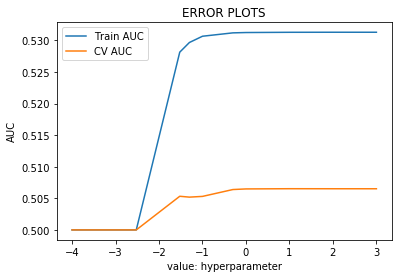

In [336]:
## Fit Logistic Regression to Train Data
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
C=[0.0001,0.003, 0.03,0.05, 0.1,0.5,1,10,100,1000]
train_auc = []
cv_auc = []
for value in C:
    i=0
    LR=LogisticRegression(penalty='l1',C=value,class_weight='balanced')
    LR.fit(train_tfidfw2v,y_train)
    y_train_pred =  LR.predict_proba(train_tfidfw2v)[:,1]
    y_cv_pred =  LR.predict_proba(cv_tfidfw2v)[:,1]
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.plot((np.log10(C)), train_auc, label='Train AUC')
plt.plot((np.log10(C)), cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("value: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show() 

In [369]:
optimal_C3 = 1

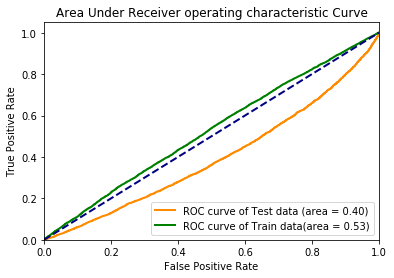

In [370]:
## finding roc_auc on test data
from sklearn.metrics import roc_curve, auc


LR = LogisticRegression(penalty='l1',C=optimal_C3,class_weight='balanced')
LR.fit(X_train_avgw2v, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_train, LR.predict_proba(X_train_avgw2v)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, LR.predict_proba(X_test_avgw2v)[:,1])

# Compute area under roc curve
area_train = auc(train_fpr, train_tpr)
area_test = auc(test_fpr, test_tpr)

lw =2
plt.plot(test_fpr, test_tpr, color='darkorange',lw=lw, label='ROC curve of Test data (area = %0.2f)' % area_test)
plt.plot(train_fpr, train_tpr, color='green',lw=lw, label='ROC curve of Train data(area = %0.2f)' % area_train)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Area Under Receiver operating characteristic Curve')
plt.legend(loc="lower right")

Text(33,0.5,'True Label')

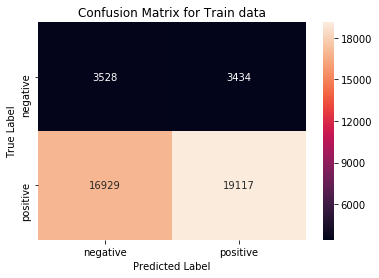

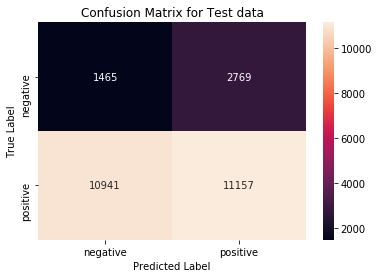

In [371]:
#Confusion matrix for train data
from sklearn.metrics import confusion_matrix    
plt.figure()
cm = confusion_matrix(y_train, LR.predict(X_train_avgw2v))
class_label = ["negative", "positive"]
df_cm_train = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm_train , annot = True, fmt = "d")
plt.title("Confusion Matrix for Train data")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

#Confusion matrix for test data
plt.figure()
cm = confusion_matrix(y_test, LR.predict(X_test_avgw2v))
class_label = ["negative", "positive"]
df_cm_test = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm_test , annot = True, fmt = "d")
plt.title("Confusion Matrix for Test data")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

#### Observation -
#### From the above curve we can see that AUC of train data 0.53 and test data is 0.40.
#### From confusion matrix of train data we can see that only 3528 negative points are correclty classified as negative and 191117 positive points are correctly classified as positive points.
#### From confusion matrix of test data we can see that 1465 negative points are correclty classified as negative and 11157 points are correctly classified as positive points.¶

In [372]:
def show_most_informative_features(vectorizer, LR, n=10):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(LR.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    print("\t\t\tNegative\t\t\t\t\t\tPositive")
    print("________________________________________________________________________________________________")
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print("\t%.4f\t%-15s\t\t\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))
        
show_most_informative_features(vectorizer,clf)
#Code Reference:https://stackoverflow.com/questions/11116697/how-to-get-most-informative-features-for-scikit-learn-classifiers

			Negative						Positive
________________________________________________________________________________________________
	-20.3551	puts           				15.7636	seasonings     
	-15.6589	dassant        				13.6557	alone          
	-14.8150	disappointment 				12.8133	yorkie         
	-14.1239	ostrim         				12.5924	curl           
	-13.8504	terribleness   				12.4355	ghirardelli    
	-13.7010	vinci          				11.8923	weedy          
	-11.8509	sadie          				11.6989	healthfood     
	-11.3467	moldy          				10.6188	goodbye        
	-11.2562	brûl           				10.5409	stable         
	-11.2461	transit        				10.2100	ey             


In [373]:
# Variables that will be used for  making table in Conclusion part of this assignment

tfidfw2v_L1_grid_C = optimal_C3
ROC_tfidfw2v_L1_Train = area_train
ROC_tfidfw2v_L1_Test = area_test

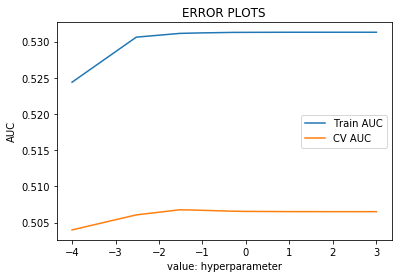

In [353]:
## Fit Logistic Regression to Train Data
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
C=[0.0001,0.003, 0.03,0.05, 0.1,0.5,1,10,100,1000]
train_auc = []
cv_auc = []
for value in C:
    i=0
    LR=LogisticRegression(penalty='l2',C=value,class_weight='balanced')
    LR.fit(train_tfidfw2v,y_train)
    y_train_pred =  LR.predict_proba(train_tfidfw2v)[:,1]
    y_cv_pred =  LR.predict_proba(cv_tfidfw2v)[:,1]
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.plot((np.log10(C)), train_auc, label='Train AUC')
plt.plot((np.log10(C)), cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("value: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show() 

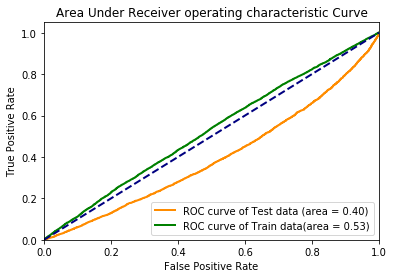

In [354]:
## finding roc_auc on test data
from sklearn.metrics import roc_curve, auc


LR = LogisticRegression(penalty='l1',C=optimal_C,class_weight='balanced')
LR.fit(X_train_avgw2v, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_train, LR.predict_proba(X_train_avgw2v)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, LR.predict_proba(X_test_avgw2v)[:,1])

# Compute area under roc curve
area_train = auc(train_fpr, train_tpr)
area_test = auc(test_fpr, test_tpr)

lw =2
plt.plot(test_fpr, test_tpr, color='darkorange',lw=lw, label='ROC curve of Test data (area = %0.2f)' % area_test)
plt.plot(train_fpr, train_tpr, color='green',lw=lw, label='ROC curve of Train data(area = %0.2f)' % area_train)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Area Under Receiver operating characteristic Curve')
plt.legend(loc="lower right")

Text(33,0.5,'True Label')

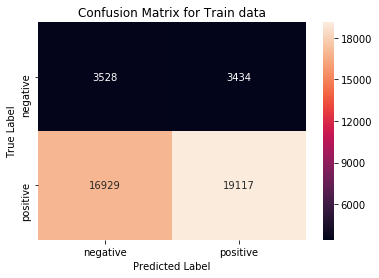

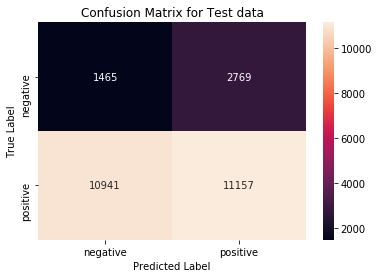

In [355]:
#Confusion matrix for train data
from sklearn.metrics import confusion_matrix    
plt.figure()
cm = confusion_matrix(y_train, LR.predict(X_train_avgw2v))
class_label = ["negative", "positive"]
df_cm_train = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm_train , annot = True, fmt = "d")
plt.title("Confusion Matrix for Train data")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

#Confusion matrix for test data
plt.figure()
cm = confusion_matrix(y_test, LR.predict(X_test_avgw2v))
class_label = ["negative", "positive"]
df_cm_test = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm_test , annot = True, fmt = "d")
plt.title("Confusion Matrix for Test data")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

### Observation
#### From the above curve we can see that AUC of train data 0.53 and test data is 0.40.
#### From confusion matrix of train data we can see that 3528 negative points are correclty classified as negative and 19117 positive points are correctly classified as positive points.
#### From confusion matrix of test data we can see that 1465 negative points are correclty classified as negative and 11157 points are correctly classified as positive points.¶

In [357]:
def show_most_informative_features(vectorizer, LR, n=10):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(LR.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    print("\t\t\tNegative\t\t\t\t\t\tPositive")
    print("________________________________________________________________________________________________")
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print("\t%.4f\t%-15s\t\t\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))
        
show_most_informative_features(vectorizer,clf)
#Code Reference:https://stackoverflow.com/questions/11116697/how-to-get-most-informative-features-for-scikit-learn-classifiers

			Negative						Positive
________________________________________________________________________________________________
	-20.3551	puts           				15.7636	seasonings     
	-15.6589	dassant        				13.6557	alone          
	-14.8150	disappointment 				12.8133	yorkie         
	-14.1239	ostrim         				12.5924	curl           
	-13.8504	terribleness   				12.4355	ghirardelli    
	-13.7010	vinci          				11.8923	weedy          
	-11.8509	sadie          				11.6989	healthfood     
	-11.3467	moldy          				10.6188	goodbye        
	-11.2562	brûl           				10.5409	stable         
	-11.2461	transit        				10.2100	ey             


In [358]:
# Variables that will be used for  making table in Conclusion part of this assignment

tfidfw2v_L2_grid_C = optimal_C
ROC_tfidfw2v_L2_Train = area_train
ROC_tfidfw2v_L2_Test = area_test

In [374]:
# Creating table using PrettyTable library
from prettytable import PrettyTable

# Names of models
names = ['LR(l2|CrossValidation) for BoW',\
         'LR(l1|CrossValidation) for BoW',\
         'LR(l2|CrossValidation) for TFIDF',\
         'LR(l1|CrossValidation) for TFIDF',\
         'LR(l2|CrossValidation) for Avg_Word2Vec',\
         'LR(l1|CrossValidation) for Avg_Word2Vec',\
         'LR(l2|CrossValidation) for tfidf_Word2Vec',\
         'LR(l1|CrossValidation) for tfidf_Word2Vec']
         
      

# Optimal values of C i.e. (1/lambda)
optimal_C = [bow_l2_grid_C,bow_l1_grid_C,\
             tfidf_l2_grid_C,tfidf_l1_grid_C,\
             avgw2v_L2_grid_C,avgw2v_L1_grid_C,\
             tfidfw2v_L2_grid_C,tfidfw2v_L1_grid_C,]
# Test accuracies
ROC_test =  [ROC_L2_Test,ROC_L1_Test,\
             ROC_tfidf_L2_Test,ROC_tfidf_L2_Test,\
             ROC_avgw2v_L2_Test,ROC_avgw2v_L1_Test,\
             ROC_tfidfw2v_L2_Test,ROC_tfidfw2v_L1_Test,]

numbering = [1,2,3,4,5,6,7,8]

# Initializing prettytable
ptable = PrettyTable()

# Adding columns
ptable.add_column("S.NO.",numbering)
ptable.add_column("MODEL",names)
ptable.add_column("Best C(1/lambda)",optimal_C)
ptable.add_column("ROC Score",ROC_test)


# Printing note regarding information of "MODEL" column in the table
print("NOTE:- In the Table below in 'MODEL' column :")
print("\t LR(l2|CV) : Logistic Regression with L2 regularisation as an estimator in simple CV")
print("\t LR(l1|CV) : Logistic Regression with L1 regularisation as an estimator in simple CV")
# Printing the Table
print(ptable)


NOTE:- In the Table below in 'MODEL' column :
	 LR(l2|CV) : Logistic Regression with L2 regularisation as an estimator in simple CV
	 LR(l1|CV) : Logistic Regression with L1 regularisation as an estimator in simple CV
+-------+-------------------------------------------+------------------+---------------------+
| S.NO. |                   MODEL                   | Best C(1/lambda) |      ROC Score      |
+-------+-------------------------------------------+------------------+---------------------+
|   1   |       LR(l2|CrossValidation) for BoW      |        1         |  0.9355983681657175 |
|   2   |       LR(l1|CrossValidation) for BoW      |        1         |  0.9345507577723194 |
|   3   |      LR(l2|CrossValidation) for TFIDF     |        1         |  0.9407362469145366 |
|   4   |      LR(l1|CrossValidation) for TFIDF     |        1         |  0.9407362469145366 |
|   5   |  LR(l2|CrossValidation) for Avg_Word2Vec  |        3         |  0.9375364807934835 |
|   6   |  LR(l1|Cross

In [ ]:
 1